In [0]:
### GENERAL REQUIREMENTS - will install the libraries
import numpy as np
import math
import pandas as pd
from google.colab import files ### to interact between google colab and local harddrive
import sys
import requests
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import io
import time # to avoid errors, we sometime use time.sleep(N) before retrying a request
import json # the input data have typically a json structure
import getpass
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

!pip install sddk ### our own package under construction, always install to have an up-to-date version
import sddk

In [0]:
### to work with spatial data
!pip install contextily==1.0rc2
import contextily as ctx # basemaps
import shapely # geometries, e.g. "POINT (23931.23 45492.17)"
!pip install geopandas==0.6.2 ### for some reasons, 0.6.3 does not work, so let's force 0.6.2
import geopandas # pandas DataFrame + geometry
!pip install pyshp
import shapefile

     |████████████████████████████████| 18.0MB 200kB/s 
     |████████████████████████████████| 921kB 3.2MB/s 
     |████████████████████████████████| 10.1MB 9.2MB/s 
     |████████████████████████████████| 11.8MB 48.3MB/s 
     |████████████████████████████████| 225kB 3.1MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=723b56d45399b8563c5a3ae7aa2325add4fc3147cb7f0b96555d26df8300f025
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
### configure session and groupurl
### in the case of "SDAM_root", the folder owner is Vojtech with username 648597@au.dk
conf = sddk.configure_session_and_url("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


# Roman Cities - Hanson (from online CSV) - preprocessing
Feel free to skip to next section



In [0]:
### ROMAN CITIES AS A DATAFRAME
url = "http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv"
response = requests.get(url).text
file_object = io.StringIO(response)
cities_raw = pd.read_csv(file_object)
cities_raw.head(3) 

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Longitude (X),Latitude (Y),Select Bibliography
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,22.933333,38.583333,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,23.734088,38.083473,BNP; DGRG; PECS; Sear 2006.
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,23.219702,38.452606,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...


In [0]:
cities_area = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Areas_OxREP.csv").text))
cities_area.head(3)

,Primary Key,Area,Estimate Basis
0,Hanson2016_1,16,Walls
1,Hanson2016_4,52,Inhabited area
2,Hanson2016_7,130,Walls


In [0]:
len(cities_area)

885

In [0]:
cities_status_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Civic%20Status_OxREP.csv").text))
cities_status_raw.head(3)

,Primary Key,Civic Status,Notes
0,Hanson2016_1,Rights and privileges,libera
1,Hanson2016_4,Rights and privileges,libera
2,Hanson2016_8,Rights and privileges,libera et immunis


In [0]:
cities_status = pd.DataFrame(cities_status_raw.groupby("Primary Key")["Civic Status"].apply(list))
cities_status.head(5)

,Civic Status
Primary Key,
Hanson2016_1,[Rights and privileges]
Hanson2016_1000,[Municipium]
Hanson2016_1001,[Municipium]
Hanson2016_1002,"[Colonia, Municipium]"
Hanson2016_1003,[Municipium]


In [0]:
cities_monuments_raw = pd.read_csv(io.StringIO(requests.get("http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Monuments_OxREP.csv").text))
cities_monuments_raw.head(3)

,Primary Key,Structure
0,Hanson2016_1,Acropolis
1,Hanson2016_1,Agora
2,Hanson2016_1,Temple of Apollo


In [0]:
print(len(cities_monuments_raw))
cities_monuments = pd.DataFrame(cities_monuments_raw.groupby("Primary Key")["Structure"].apply(list))
print(len(cities_monuments))

9472
1208


In [0]:
cities_monuments

,Structure
Primary Key,
Hanson2016_,[Agora?]
Hanson2016_1,"[Acropolis, Agora, Temple of Apollo, Theatre, ..."
Hanson2016_10,"[Acropolis, Gymnasium, Sanctuary of Poseidon, ..."
Hanson2016_100,"[Acropolis, Fountain, Gymnasium, Gymnasium, Hi..."
Hanson2016_1000,[Temple]
...,...
Hanson2016_993,"[Amphitheatre, Basilica, Baths?, Forum, Temple..."
Hanson2016_995,"[Aqueduct, Baths, Forum, Unidentified public b..."
Hanson2016_996,"[Temple, Walls]"


In [0]:
cities = pd.merge(cities_raw, cities_area, on="Primary Key", how="left") 
cities = pd.merge(cities, cities_status, on="Primary Key", how="left")
cities = pd.merge(cities, cities_monuments, on="Primary Key", how="left")
len(cities)

1388

In [0]:
def get_number_of_structures(row):
  try: num = len(row["Structure"])
  except: num = 0
  return num
cities["num_of_structures"] = cities.apply(lambda row: get_number_of_structures(row), axis=1)

In [0]:
sddk.write_file("SDAM_data/hanson_2016_mergred.json", cities, conf)

A file with the same name ("hanson_2016_mergred.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/hanson_2016_mergred.json"


# To start with preprocessed cities

In [0]:
cities = sddk.read_file("SDAM_data/hanson_2016_mergred.json", "df", conf)

In [195]:
### ROMAN CITIES AS A GEODATAFRAME
cities = geopandas.GeoDataFrame(cities, geometry=geopandas.points_from_xy(cities["Longitude (X)"], cities["Latitude (Y)"]))
cities.drop(columns=["Longitude (X)", "Latitude (Y)"], inplace=True)
cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,POINT (22.93333 38.58333)
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,POINT (23.73409 38.08347)
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,POINT (23.21970 38.45261)
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,52.0,Inhabited area,[Rights and privileges],"[Shrine of Aeacus, Stadium, Temple of Aphrodit...",8,POINT (23.42850 37.75007)
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,NaN,None,None,"[Acropolis, Agora, Gymnasium, Temple of Aphrod...",8,POINT (22.35572 38.14795)


In [0]:
### the overall length of the dataset
len(cities)

1388

In [0]:
### number of cities with specified area
len(cities[cities["Area"].notnull()])

885

In [0]:
### number of cities with at least one monument
len(cities[cities["num_of_structures"]> 0])

1207

In [0]:
### number of cities with at least one monument & with specified area 
len(cities[(cities["num_of_structures"]> 0) & (cities["Area"].notnull())])

851

In [0]:
cities["Area"] = cities["Area"].astype(float)

In [196]:
### generate an ID (to be used for future merge)
cities["ID"] = cities.apply(lambda row: row["Primary Key"].partition("_")[2], axis=1)
cities.head(3)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry,ID
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,16.0,Walls,[Rights and privileges],"[Acropolis, Agora, Temple of Apollo, Theatre, ...",5,POINT (22.93333 38.58333),1
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,NaN,None,None,"[Sanctuary of Apollo Argyieus, Sanctuary of He...",3,POINT (23.73409 38.08347),2
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,NaN,None,None,"[Acropolis, Agora, Fountain, Temple of Apollo ...",7,POINT (23.21970 38.45261),3


# Population sizes from Hanson 2019

In [0]:
### for population sizes, we will use data from this article: Hanson, J., Ortman, S., Bettencourt, L., & Mazur, L. (2019). Urban form, infrastructure and spatial organisation in the Roman Empire. Antiquity, 93(369), 702-718. doi:10.15184/aqy.2018.192
### we extracted their sample of 125 cities into a google spreadsheet, which can now be imported into python

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

### authorize google sheets
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
# establish connection with particular sheet by its url:
sh = gc.open_by_url("https://docs.google.com/spreadsheets/d/1obqgDoE7HC-p3Y-fYhYhfcQZe1itxheOW58cxqLFLt0/edit?usp=sharing")

In [198]:
hanson2019 = get_as_dataframe(sh.worksheet("HansenOrtmann2019_dataset.csv"))
hanson2019 = hanson2019[hanson2019["ID"].notnull()].iloc[:, : 9] ### we need only some columns
hanson2019.head(5)

,ID,Name,Area (ha),Population,Forum/agoraarea(m2),Streetarea(m2),Streetlength(m),Streetwidth(m),Blockarea(m2)
0,14,Athenae,225.0,58114.0,25967.0,NaN,NaN,NaN,NaN
1,19,Cassope,18.0,1989.0,NaN,27335.0,4522.0,7.0,9996.0
2,26,Corinthia,241.0,63700.0,15905.0,NaN,NaN,NaN,NaN
3,110,Alexandria,972.0,410535.0,75000.0,1072216.0,58399.0,21.0,140509.0
4,172,Carthago,343.0,102170.0,15000.0,NaN,NaN,NaN,NaN


In [199]:
len(hanson2019)

125

In [200]:
### total urban population
hanson2019["Population"].sum()

3039375.0

In [0]:
### clean the "IDs"
hanson2019["ID"] = hanson2019["ID"].astype(str).str.replace(" ", "")

In [0]:
cities_pop = pd.merge(cities, hanson2019, on="ID", how="left")

# Fitting the model for estimating population sizes.

There is an equation to calculate population sizes of ancient cities. It is as 
follows:

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area.

Thus, once we have area size for 885 Roman cities, to estimate their population sizes we just have to have right values for the coefficient *d* and the exponent *p*. And this is exactly what has been produced by Hanson & Ortman in their 2017 article by fitting a model against a diverse sample of Greco-Roman cities for which we have more robust population estimates based on other methods.





In their article, Hanson and Ortman offer the following values for *p* and *d*. 

*p* = 1.34

*d* = 41.84

Using these values, we are able to obtain approximately the same values for population sizes as the ones they publish in the supplementary data to their 2019 article.

In [203]:
### hanson&ortman2019 sample population data:
yd = cities_pop[cities_pop["Population"]>0]["Population"].values
print(list(yd))

[58114.0, 1989.0, 63700.0, 410535.0, 102170.0, 4837.0, 7037.0, 3085.0, 3085.0, 6034.0, 8633.0, 5975.0, 2655.0, 11979.0, 15580.0, 71587.0, 13870.0, 4653.0, 3085.0, 18882.0, 6567.0, 56053.0, 47672.0, 1030.0, 19404.0, 907.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 6034.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33807.0, 4291.0, 3104.0, 4837.0, 16187.0, 7582.0, 4327.0, 38476.0, 28211.0, 46171.0, 40666.0, 9938.0, 6767.0, 3590.0, 7628.0, 4291.0, 41539.0, 17338.0, 6767.0, 13426.0, 14596.0, 6368.0, 5022.0, 6171.0, 2290.0, 1157.0, 7172.0, 9498.0, 9327.0, 2922.0, 1030.0, 12211.0, 7401.0, 15086.0, 35017.0, 9938.0, 6567.0, 2601.0, 3469.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3085.0, 7376.0, 2760.0, 923406.0, 5782.0, 9280.0, 7790.0, 907.0, 4916.0, 1718.0, 2290.0, 19667.0, 7790.0, 1062.0, 8209.0, 6567.0, 14841.0, 2828.0, 458.0, 5399.0, 10608.0, 2601.0, 5399.0, 3085.0, 29368.0, 7999.0, 70860.0, 1157.0, 3420.0, 4291.0, 7188.0, 9938.0, 7790.0, 53334.0, 3

In [204]:
### FIRST COARSE MODEL 

### estimates based on p=1.34 and d=41.84:
exp = 1.34 ### to avoid confusion with p values
dens = 41.84 ### to fit data including Rome, alternatively, try: 41.84 (best fitting density coeffecient for a smaple without Rome)
### area data: 
xd = cities_pop[cities_pop["Population"]>0]["Area"].values.round(4)
### estimate 
working_model = list(dens*(xd**exp).round())
print(working_model)

[59370.96000000001, 2008.3200000000002, 65103.04000000001, 421747.2, 104432.64000000001, 4895.280000000001, 7070.960000000001, 3138.0000000000005, 3138.0000000000005, 42383.920000000006, 8786.400000000001, 6066.8, 2635.92, 12175.44, 15857.36, 73178.16, 14100.080000000002, 4727.92, 3138.0000000000005, 19204.56, 6652.56, 57613.68000000001, 48659.920000000006, 1046.0, 19748.480000000003, 669.44, 7698.56, 23848.800000000003, 6861.76, 7489.360000000001, 18158.56, 9874.240000000002, 8326.16, 5271.84, 6066.8, 37614.16, 7070.960000000001, 9665.04, 2008.3200000000002, 17405.440000000002, 15355.28, 34476.16, 4351.360000000001, 3138.0000000000005, 4895.280000000001, 16359.44, 7698.56, 7489.360000000001, 39162.240000000005, 28744.08, 46986.32000000001, 41421.600000000006, 10083.44, 6861.76, 3640.0800000000004, 7698.56, 4351.360000000001, 42383.920000000006, 17656.480000000003, 15606.320000000002, 13639.840000000002, 14853.2, 6443.360000000001, 5104.4800000000005, 6276.000000000001, 460.24, 1171.52

In [205]:
from scipy.stats import pearsonr as corr
corr(working_model, yd)


(0.9986874516926364, 1.3078781126507134e-160)

Ok, it is quite good.  But it also somehow overestimates some values. Let's try find a better fitting model, perhaps just by including more decimal numbers.

Let's turn to least-squares.


In [206]:
RSS_list = []
exp_values = np.linspace(1.33,1.35, 10001)
for exp in exp_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
exp = exp_values[np.where(RSS_array==min(RSS_array))][0]
exp

1.336068

In [207]:
### let's make the same for the density coefficient:

RSS_list = []
dens_values = np.linspace(41,42, 10001)
for dens in dens_values: ### for each from 1001 values of exp (or: p) between 1.33 and 1.35:
  y_model = dens*(xd**exp) ## tune the model
  RSS = sum(np.square(y_model - yd)) # calculate RSS
  RSS_list.append(RSS) # add it to the list of all RSS
RSS_array = np.array(RSS_list)

### now we have a more precise exponent
dens = dens_values[np.where(RSS_array==min(RSS_array))][0]
dens

41.8398

In [208]:
y_model_fitted = dens*(xd**exp)
y_model_fitted = y_model_fitted.round()
print(list(y_model_fitted))

[58112.0, 1989.0, 63698.0, 410502.0, 102074.0, 4837.0, 6969.0, 3086.0, 3086.0, 41538.0, 8633.0, 5976.0, 2601.0, 11979.0, 15580.0, 71584.0, 13870.0, 4653.0, 3086.0, 18882.0, 6567.0, 56393.0, 47670.0, 1030.0, 19404.0, 673.0, 7582.0, 23429.0, 6767.0, 7376.0, 17849.0, 9718.0, 8209.0, 5210.0, 5976.0, 36851.0, 6969.0, 9498.0, 1989.0, 17084.0, 15086.0, 33806.0, 4291.0, 3086.0, 4837.0, 16077.0, 7582.0, 7376.0, 38397.0, 28210.0, 46036.0, 40589.0, 9938.0, 6767.0, 3590.0, 7582.0, 4291.0, 41538.0, 17338.0, 15332.0, 13391.0, 14596.0, 6368.0, 5022.0, 6171.0, 458.0, 1157.0, 7172.0, 9498.0, 12211.0, 2922.0, 1030.0, 12211.0, 2290.0, 15086.0, 35016.0, 9938.0, 6567.0, 2601.0, 3420.0, 2138.0, 6567.0, 4471.0, 26781.0, 4471.0, 5589.0, 3086.0, 7376.0, 2760.0, 923313.0, 5589.0, 9280.0, 6368.0, 907.0, 4837.0, 1700.0, 2290.0, 14596.0, 4837.0, 1030.0, 8209.0, 6567.0, 14841.0, 2760.0, 458.0, 5399.0, 10608.0, 2290.0, 5399.0, 3086.0, 19666.0, 7999.0, 37159.0, 788.0, 3420.0, 4291.0, 7172.0, 9938.0, 7790.0, 53332.0, 

(0, 100000)

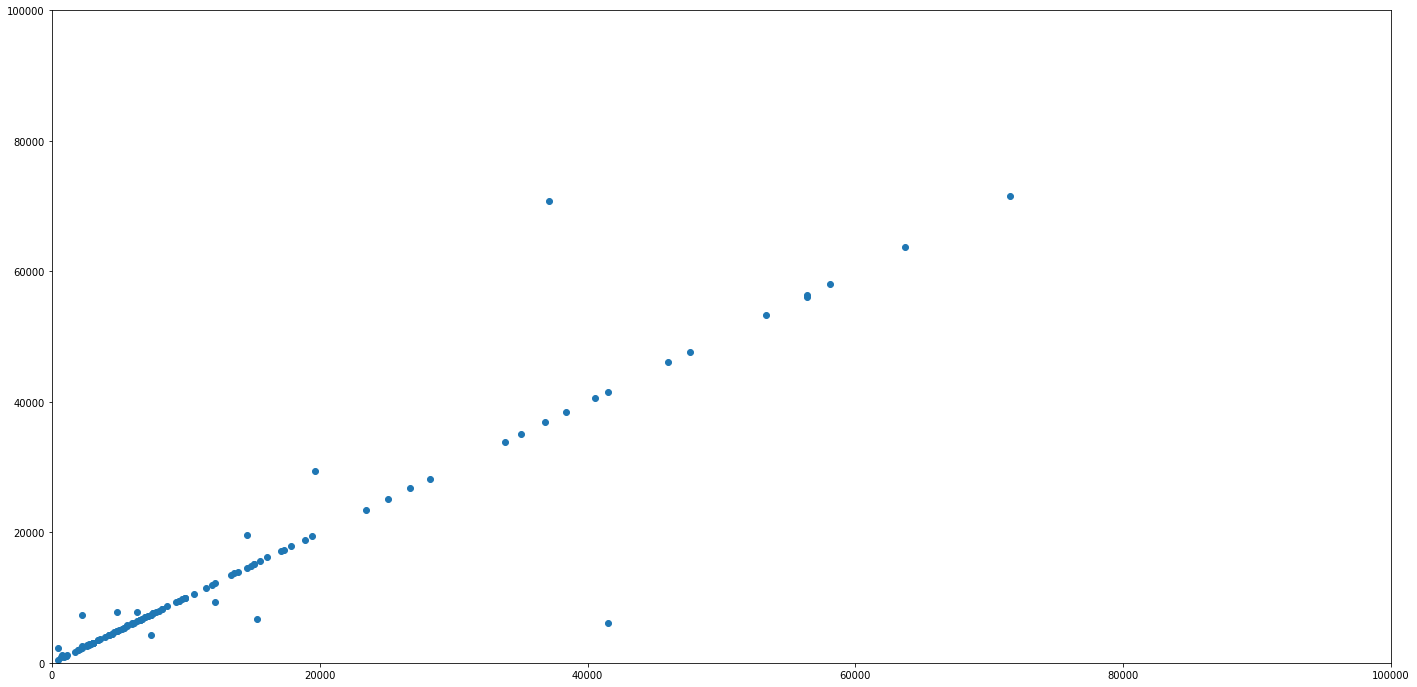

In [209]:
plt.scatter(y_model_fitted, yd)
plt.xlim(0, 100000)
plt.ylim(0, 100000)

Ok, the correlation is almost the same as above, but now we do not overestimate so much. Let's apply it to the dataset as a whole.

# Applying population estimates to the whole dataset

Let's repeat the formula for estimating population sizes

(1) <i> N = dA<sup>p</sup>  </i>,

where *N* is size of the estimated population, *d* is base coefficient for inhabitants per area, *A* is size of the area in hectares, and exponent *p* makes the hard work of modifying the density per area. To avoid confussion, here we use `dens` instead of *d* and `exp` instead of `p`

In [0]:
exp = 1.336068 ### see above
dens = 41.8398 ### see above
def get_pop_est(row):
  area = row["Area"]
  try: 
    pop_est = round(dens * (area**exp), 0)
    if math.isnan(area):
      pop_est = 1000
  except: 
    pop_est = 1000
  return pop_est
cities_pop["pop_est"] = cities_pop.apply(lambda row: get_pop_est(row), axis=1)

In [211]:
cities_pop.columns

Index(['Primary Key', 'Ancient Toponym', 'Modern Toponym', 'Province',
       'Country', 'Barrington Atlas Rank', 'Barrington Atlas Reference',
       'Start Date', 'End Date', 'Select Bibliography', 'Area',
       'Estimate Basis', 'Civic Status', 'Structure', 'num_of_structures',
       'geometry', 'ID', 'Name', 'Area (ha)', 'Population',
       'Forum/agoraarea(m2)', 'Streetarea(m2)', 'Streetlength(m)',
       'Streetwidth(m)', 'Blockarea(m2)', 'pop_est'],
      dtype='object')

In [0]:
cities_pop.drop(['Name', 'Area (ha)',
       'Forum/agoraarea(m2)', 'Streetarea(m2)', 'Streetlength(m)',
       'Streetwidth(m)', 'Blockarea(m2)',], axis=1, inplace=True)

In [0]:
cities_pop.rename({"Population":"pop_sample"}, axis=1, inplace=True)

In [0]:
### 10 cities with highest difference betwee

In [215]:
def get_pop_diff(row):
  try: return abs(row["pop_sample"] / row["pop_est"])
  except: return 0
cities_pop["pop_diff"] = cities_pop.apply(lambda row: get_pop_diff(row), axis=1)
cities_pop.sort_values("pop_diff", ascending=False).head(10)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,Area,Estimate Basis,Civic Status,Structure,num_of_structures,geometry,ID,pop_sample,pop_est,pop_diff
673,Hanson2016_674,Noviodunum (Germania Superior),Nyon,Germania Superior,Switzerland,4 or 5,18 D3,-49,NaN,Bedon 2001; Bedon et al 1988; BNP; Cornell and...,6.0,Urban grid,"[Colonia, Rights and privileges]","[Basilica, Baths, Forum, Forum, Macellum, Mith...",8,POINT (6.23839 46.38083),674,2290.0,458.0,5.000000
775,Hanson2016_776,Herculaneum,Ercolano,Italia (I Latium and Campania),Italy,3,44 F4,-600,79.0,Beloch 1880; Bispham 2007; de Ligt 2012; DGRG;...,20.0,Unspecified,[Municipium],"[Arch, Arch, Basilica, Baths, Baths, Baths (Ce...",14,POINT (14.34714 40.80586),776,7401.0,2290.0,3.231878
1161,Hanson2016_1162,Thessalonica,Thessaloniki,Macedonia,Greece,1,50 C3,-316,NaN,Cohen 1995; McEvedy 2011; Nelis-Clément and Ro...,161.0,Urban grid and walls (Late Roman),"[Colonia, Metropolis capital, Provincial capit...","[Acropolis, Agora, Arch, Arch of Galerius, Bas...",17,POINT (22.94554 40.63775),1162,70860.0,37159.0,1.906940
1047,Hanson2016_1048,Brixia,Brescia,Italia (X Venetia et Histria),Italy,2,39 G2,-89,NaN,Beloch 1880; Cornell and Mathews 1982; de Ligt...,35.0,Urban grid,"[Colonia, Municipium]","[Basilica, Forum, Sanctuary, Temple, Temple ('...",8,POINT (10.21984 45.53941),1048,7790.0,4837.0,1.610502
1157,Hanson2016_1158,Pella (Macedonia),Pella,Macedonia,Greece,2,50 C3,-413,NaN,BNP; Brunt 1971; Cornell and Mathews 1982; DGR...,100.0,"Urban grid, 1,000 by 1,000","[Colonia, Colonia, Rights and privileges, Righ...","[Acropolis, Agora, Sanctuary of Aphrodite and ...",8,POINT (22.52564 40.76004),1158,29368.0,19666.0,1.493339
1170,Hanson2016_1171,Cuicul,Djemila,Mauretania Caesariensis,Algeria,3,31 D4,96,NaN,BNP; DGRG; Lepelley 1979-1981; PECS; Quinn and...,9.0,Inhabited area,"[Colonia, Colonia]","[Aqueduct, Arch, Arch of Caracalla, Basilica, ...",19,POINT (5.73573 36.32049),1171,1157.0,788.0,1.468274
342,Hanson2016_343,Iluro,Mataró,Baetica,Spain,3,26 F5,-100,NaN,Brunt 1971; Carreras Monfort 1995-1996; Cornel...,8.0,Urban grid,"[Municipium, Rights and privileges]","[Baths, Forum, Fountain, Urban grid]",4,POINT (-4.70667 36.82261),343,907.0,673.0,1.347697
1044,Hanson2016_1045,Aquileia,Aquileia,Italia (X Venetia et Histria),Italy,2,19 F4,-181,NaN,Beloch 1880; Beloch 1886; Bispham 2007; Cornel...,80.0,Walls of Julian the Apostate,"[Colonia, Colonia, Colonia?, Municipium, Right...","[Amphitheatre, Basilica, Baths, Baths (Large),...",18,POINT (13.36705 45.76527),1045,19667.0,14596.0,1.347424
1020,Hanson2016_1021,Placentia,Piacenza,Italia (VIII Aemilia),Italy,2,39 F3,-218,NaN,Beloch 1880; Bispham 2007; Cornell and Mathews...,43.0,Urban grid,"[Colonia, Colonia, Colonia, Municipium, Rights...","[Amphitheatre, Capitolium, Forum?, Macellum, U...",7,POINT (9.69312 45.05239),1021,7790.0,6368.0,1.223304
1132,Hanson2016_1133,Sagalassus,Aglasun,Lycia et Pamphylia,Turkey,2,65 E2,-323,NaN,BNP; DGRG; Hanson 2011; Jones 1937; PECS; Sear...,20.0,Inhabited area,[Rights and privileges],"[Acropolis, Agora, Agora, Baths, Bouleuterion,...",18,POINT (30.51919 37.67674),1133,2601.0,2290.0,1.135808


In [216]:
### how many city inhabitants we have
cities_pop["pop_est"].sum()

10159670.0

In [218]:
sddk.write_file("SDAM_data/roman_cities.json", cities_pop, conf)

Your <class 'geopandas.geodataframe.GeoDataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/roman_cities.json"


# Roman Provinces

In [0]:
### (1) READ THE SHAPEFILE INTO A READER OBJECT

### here we rely on pyshp (or "shapefile") and its Reader() function
### to properly read a shapefile, you need access at least to the ".shp" file and the ".dbf" file
url_raw_filename = "http://awmc.unc.edu/awmc/map_data/shapefiles/cultural_data/political_shading/roman_empire_ad_117/shape/roman_empire_ad_117"
file_shp = urlopen(url_raw_filename + ".shp")
file_dbf = urlopen(url_raw_filename + ".dbf")
reader = shapefile.Reader(shp=file_shp, dbf=file_dbf) ### see https://pypi.org/project/pyshp/#reading-shapefiles-from-file-like-objects
### now we have a reader object to iterate over
len(reader.records())

### (2) GENERATE A GEODATAFRAME FROM THE READER OBJECT

### based on https://gist.github.com/frankrowe/6071443
features = []
field_names = [field[0] for field in reader.fields[1:]]
for element in reader.shapeRecords():
  atr = dict(zip(field_names, element.record))
  geo = element.shape.__geo_interface__
  features.append(dict(type="Feature", geometry=geo, properties=atr))

provinces = geopandas.GeoDataFrame.from_features(features)
provinces.head()

,geometry,OBJECTID,AREA,PERIMETER,NEWDIO_,NEWDIO_ID,ID,Shape_Leng,Shape_Area
0,"POLYGON ((-1.57431 55.16792, -1.50632 54.98433...",1,19.612703,35.387086,2,0,0,35.115167,19.325197
1,"POLYGON ((-4.59302 54.30514, -4.56152 54.34428...",2,0.080670,1.212228,3,0,0,1.212228,0.080670
2,"POLYGON ((-0.57376 53.75199, -0.60391 53.70755...",3,0.006408,0.311314,4,0,0,0.311314,0.006408
3,"POLYGON ((-4.60976 53.31895, -4.57282 53.35276...",4,0.092548,1.281687,5,0,0,1.281687,0.092548
4,"POLYGON ((1.68338 52.73775, 1.75385 52.69902, ...",5,0.005562,0.312915,6,0,0,0.312915,0.005562


# Orbis Transportation Network (from online geojson)

In [0]:
### add orbis transportation network
url = "https://raw.githubusercontent.com/emeeks/orbis_v2/master/base_routes.geojson"
orbis = geopandas.read_file(url)
orbis.head()

,gid,sid,tid,t,e,s,geometry
0,559512,50001,50056,road,1.91,1.82,"LINESTRING (10.89500 48.36500, 10.89344 48.354..."
1,558621,50001,50100,road,1.75,1.67,"LINESTRING (10.32700 47.72700, 10.33948 47.738..."
2,559794,50001,50293,road,2.30,2.19,"LINESTRING (11.08600 47.49200, 11.10305 47.505..."
3,560116,50001,50473,road,7.89,7.51,"LINESTRING (11.17000 46.66000, 11.16163 46.679..."
4,558775,50002,50275,road,3.23,3.07,"LINESTRING (41.24466 37.07815, 41.27515 37.077..."


# Final plot

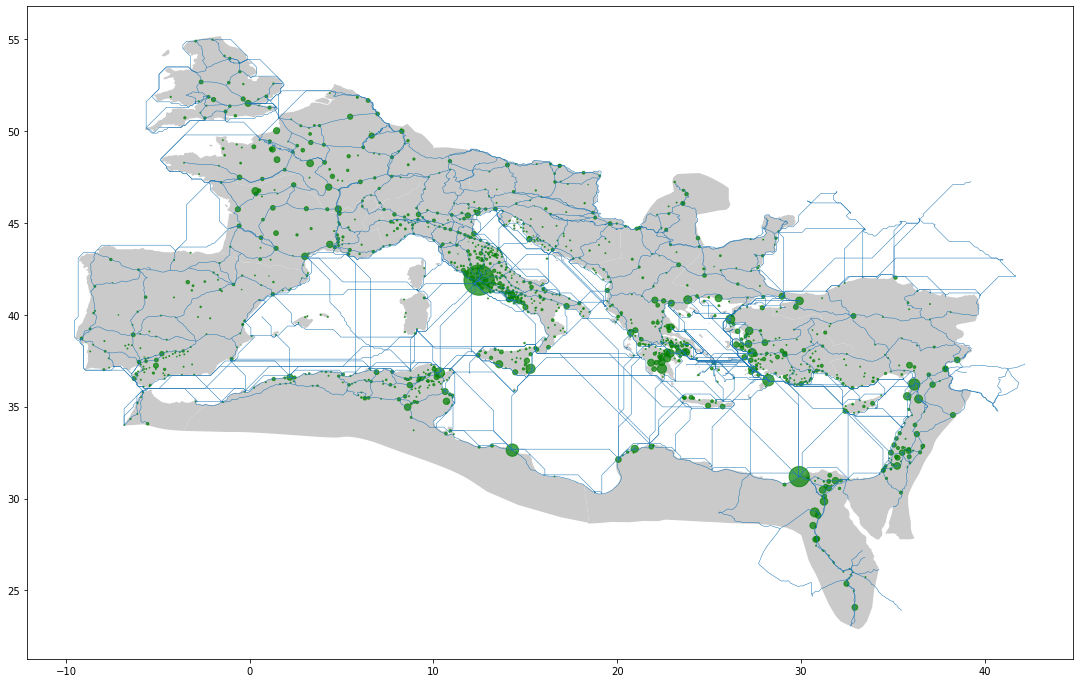

In [0]:
plt.rcParams['figure.figsize'] = [24, 12]

fig, ax = plt.subplots()
provinces.plot(color="#CACACA", ax=ax)
orbis.plot(linewidth=0.5, ax=ax)
cities_pop.plot(markersize=cities_pop["pop_est"] / 1000, color="green", alpha=0.7, ax=ax)